# Intrinsic Dimension Analysis
In this notebook, the intrinsic dimension of the token representations at different modules throughout the GPT2 model is evaluated.

Library imports:

In [1]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import transformers
import torch
import numpy as np
import matplotlib.pyplot as plt
from dadapy.data import Data
from sklearn.decomposition import PCA
import string
import DistFuncs as DF # file containing various helper functions

## Evaluating the intrinsic dimension throughout the modules with 2NN
The module inputs/outputs are extracted via hook function, and the intrinsic dimension is calculated using the `DADApy` implementation of the 2 NN method.

Based on [this DADApy tutorial](https://dadapy.readthedocs.io/en/latest/jupyter_example_3.html#Analysis-of-the-ID-of-noisy-datasets:-twoNN-vs-gride) and [this Github repo](https://github.com/diegodoimo/geometry_representations) which contains the source code from the paper ["The geometry of hidden representations of large transformer models"](https://arxiv.org/pdf/2302.00294).

Extracting Data via hook function, filtering by shape and removing duplicates:

In [2]:
# Load pre-trained model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# define input prompt
prompt = DF.read_prompt("prompt_pancake.txt")

# extract module inputs/outputs and names
data, modules =  DF.get_module_data(model, tokenizer, prompt, getInputs=True)

# filter to get the outputs/module names where outputs have the right shape
# the right shape being (# of tokens, Embedding dimension)
data, mods = DF.filter_by_shape(data, modules, ref_shape=data[1].shape)

# filter out duplicate inputs/outputs that represent the same state
data, mods = DF.filter_duplicates(data, mods)

D:\anaconda3\envs\pytorch_env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Compute intrinsic dimension via 2NN estimator:

In [3]:
# generate define module labels
decoder_labels = [f"Decoder {n}{x}" for n in range(1, 13) for x in string.ascii_lowercase[:7]]
module_labels = ["Token Embedding", "Pos. Embedding", "Full Embedding"] + decoder_labels + ["LayerNorm"]

ids, id_errs, rss = [], [], []

# first module (token embedding) is skipped
# because it contains some identical data points
for i, X in enumerate(data[1:]):
    # Initialize dadapy Data class with module representation X
    # X is 2d-numpy array with shape N x d  (N... dataset size, d... embedding dimension)
    d = Data(X)
    
    # compute the intrinsic dimension using 2nn estimator
    id, id_err, rs = d.compute_id_2NN(mu_fraction=0.85)
    ids.append(id)
    id_errs.append(id_err)
    rss.append(rs)
    
    # print results
    print(f"ID of module {module_labels[i+1]}: {id}, err: {id_err}, rs: {rs}")

Exception in thread Thread-6 (_readerthread):
Traceback (most recent call last):
  File "D:\anaconda3\envs\pytorch_env\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "D:\anaconda3\envs\pytorch_env\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "D:\anaconda3\envs\pytorch_env\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "D:\anaconda3\envs\pytorch_env\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 3: character maps to <undefined>
D:\anaconda3\envs\pytorch_env\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of 

ID of module Pos. Embedding: 28.137776740244977, err: 0.0, rs: 0.168954812539168
ID of module Full Embedding: 2.3150355267528337, err: 0.0, rs: 2.391019908847791
ID of module Decoder 1a: 2.1248966670421408, err: 0.0, rs: 1.9723466669078682
ID of module Decoder 1b: 4.097176251010527, err: 0.0, rs: 2.2350603241065303
ID of module Decoder 1c: 3.8969094623686544, err: 0.0, rs: 10.89598374266242
ID of module Decoder 1d: 3.8403596114830236, err: 0.0, rs: 11.381722221575322
ID of module Decoder 1e: 3.4551567116011905, err: 0.0, rs: 2.386008220469602
ID of module Decoder 1f: 3.1424988622138406, err: 0.0, rs: 15.559771155603238
ID of module Decoder 1g: 2.8255129208257834, err: 0.0, rs: 23.12517261889419
ID of module Decoder 2a: 2.830277492534997, err: 0.0, rs: 2.7641652000315005
ID of module Decoder 2b: 6.756353577864135, err: 0.0, rs: 2.4639400704565926
ID of module Decoder 2c: 7.78976451364404, err: 0.0, rs: 5.9309946516409076
ID of module Decoder 2d: 3.4534530388495948, err: 0.0, rs: 24.9609

Plot results:

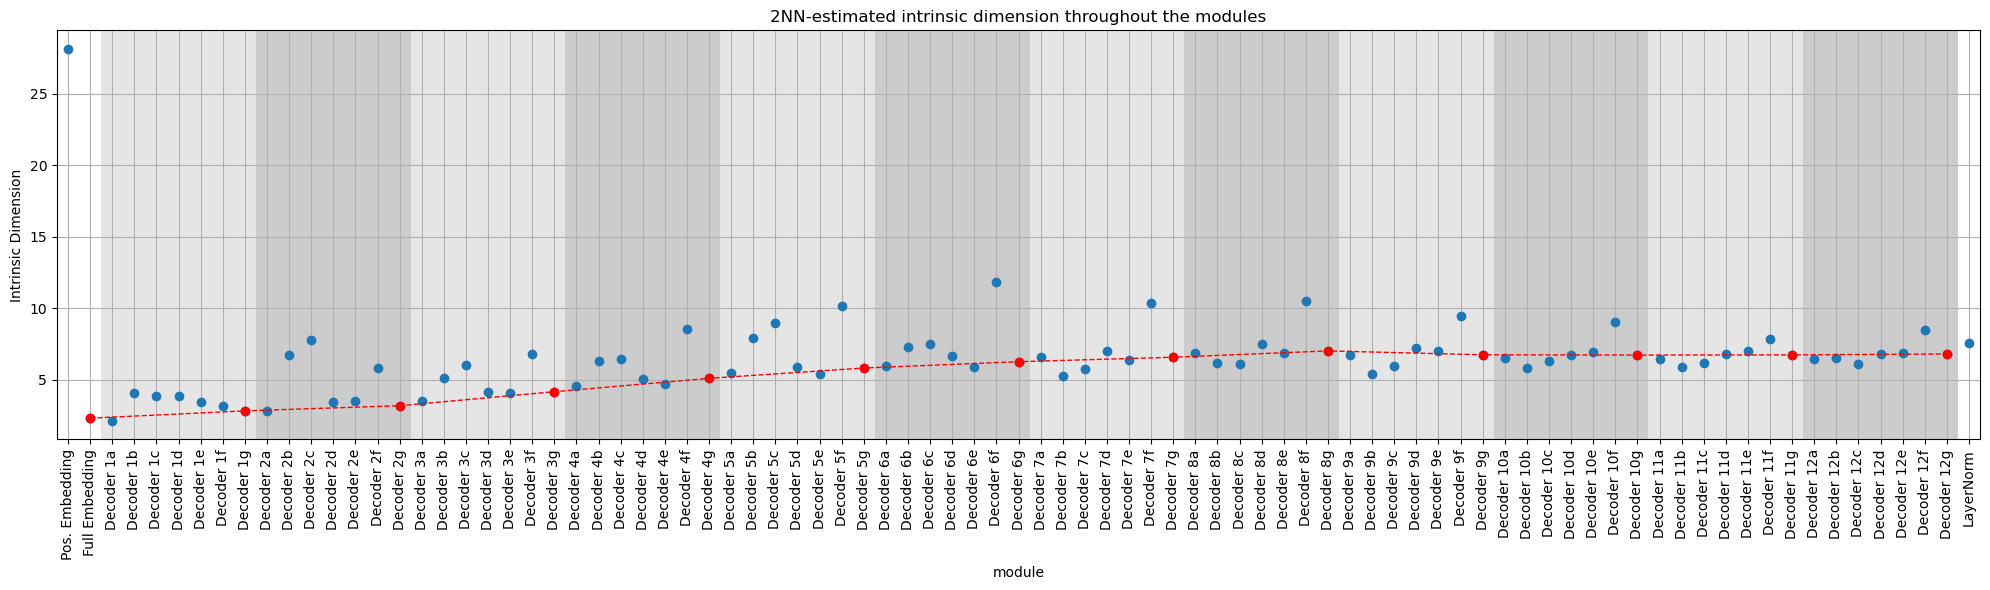

In [4]:
# filter for only the GPT2Block-outputs
# to highlight them in the graph
gpt2block_mask = [m == "GPT2Block" for m in mods]
# add position of embedding & first dropout output after embedding
gpt2block_mask[2] = True

# generate x-axis values
x_pos = np.arange(len(mods))

# create figure
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(x_pos[gpt2block_mask], np.array(ids)[gpt2block_mask[1:]], "r--o", lw=1, zorder=5) # gpt2 blocks
ax.scatter(x_pos[1:], ids, zorder=4) # all modules

# visualize decoder blocks
# comment this out if you think it's too much
for i in range(0, 12):
    if i%2:
        plt.axvspan(i*7+2.5, i*7+9.5, facecolor="grey", alpha=0.4, zorder=-100)
    else:
        plt.axvspan(i*7+2.5, i*7+9.5, facecolor="grey", alpha=0.2, zorder=-100)

ax.set_title(f"2NN-estimated intrinsic dimension throughout the modules")
ax.set_xlabel("module")
ax.set_ylabel("Intrinsic Dimension")
ax.set_xticks(x_pos[1:], module_labels[1:], rotation=90)
ax.set_xlim(min(x_pos[1:])-0.5, max(x_pos)+0.5)
ax.grid()
fig.tight_layout()
plt.show()

## Local Principal Component Analysis
Using the previously extracted and filtered module inputs/outputs, the number of principal components necessary to capture 90% of the variance is calculated using the `sklearn.decompose` implementation of PCA.

Performing PCA:

In [5]:
threshold = 0.90  # Threshold for cumulative explained variance
n_components_needed = []  

for i, X in enumerate(data[1:]):
    pca = PCA()
    pca.fit(X)
    
    # Compute cumulative explained variance ratio
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # Find the number of components needed to reach the threshold
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    n_components_needed.append(n_components)

    print(f"Number of components needed for 90% variance in mod. {module_labels[i+1]}: {n_components}")

Number of components needed for 90% variance in mod. Pos. Embedding: 3
Number of components needed for 90% variance in mod. Full Embedding: 114
Number of components needed for 90% variance in mod. Decoder 1a: 179
Number of components needed for 90% variance in mod. Decoder 1b: 91
Number of components needed for 90% variance in mod. Decoder 1c: 30
Number of components needed for 90% variance in mod. Decoder 1d: 33
Number of components needed for 90% variance in mod. Decoder 1e: 157
Number of components needed for 90% variance in mod. Decoder 1f: 157
Number of components needed for 90% variance in mod. Decoder 1g: 108
Number of components needed for 90% variance in mod. Decoder 2a: 97
Number of components needed for 90% variance in mod. Decoder 2b: 45
Number of components needed for 90% variance in mod. Decoder 2c: 68
Number of components needed for 90% variance in mod. Decoder 2d: 111
Number of components needed for 90% variance in mod. Decoder 2e: 142
Number of components needed for 90

Plot results:

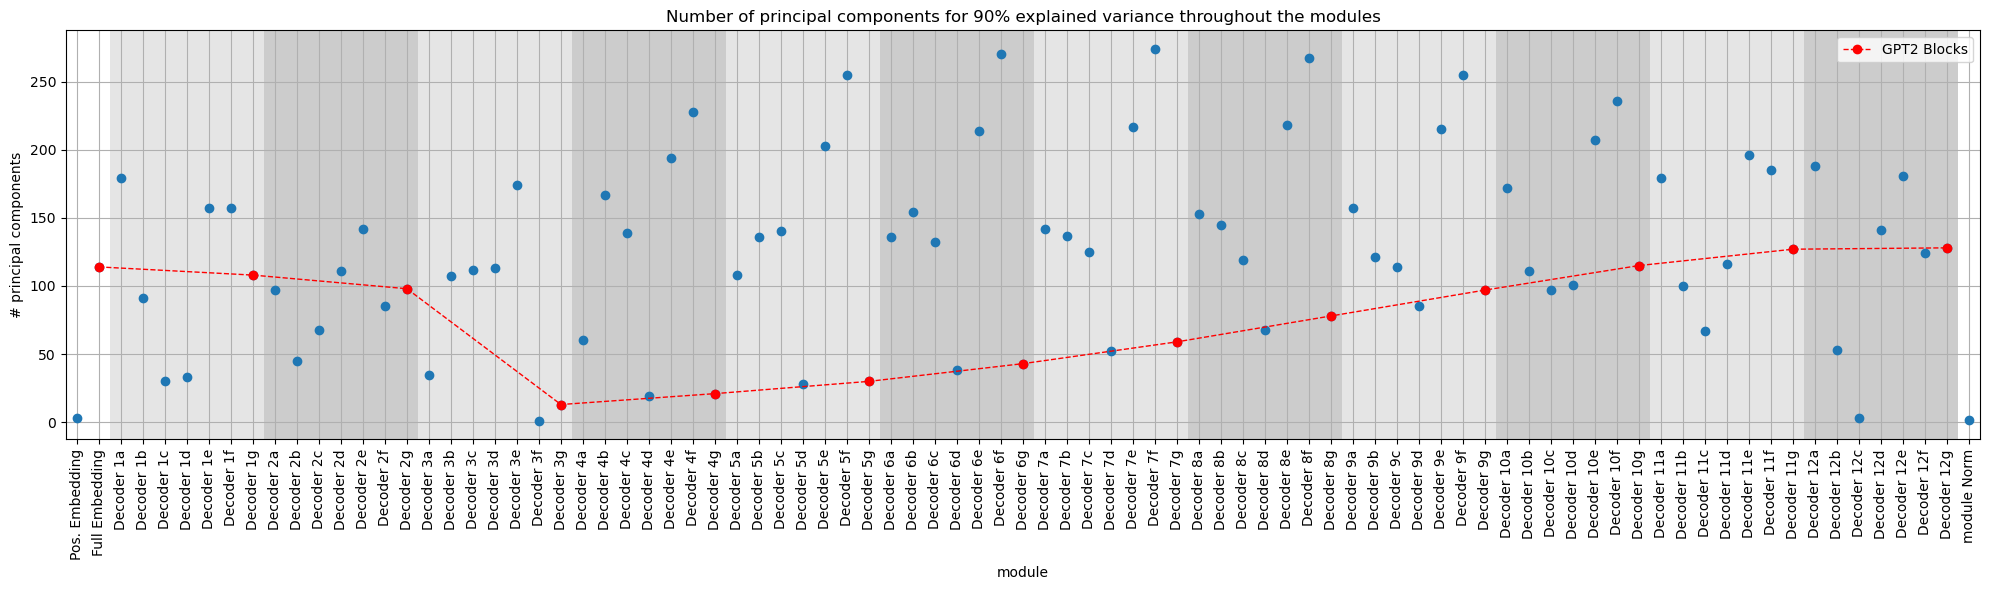

In [6]:
# create figure
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(x_pos[gpt2block_mask], np.array(n_components_needed)[gpt2block_mask[1:]], "r--o", lw=1, zorder=5, label="GPT2 Blocks")
ax.scatter(x_pos[1:], n_components_needed, zorder=4)

# visualize decoder blocks
for i in range(0, 12):
    if i%2:
        plt.axvspan(i*7+2.5, i*7+9.5, facecolor="grey", alpha=0.4, zorder=-100)
    else:
        plt.axvspan(i*7+2.5, i*7+9.5, facecolor="grey", alpha=0.2, zorder=-100)

ax.set_title(f"Number of principal components for 90% explained variance throughout the modules")
ax.set_xlabel("module")
ax.set_ylabel("# principal components")
ax.set_xticks(x_pos[1:], ticks[1:], rotation=90)
ax.set_xlim(min(x_pos[1:])-0.5, max(x_pos)+0.5)
ax.grid()
ax.legend()
fig.tight_layout()
plt.show()

#### Comparing results for different thresholds:
Perform PCA:

In [7]:
thresholds = np.arange(0.75, 1, 0.05)  # Thresholds for cumulative explained variance
n_components_threshold = np.zeros((len(thresholds), len(data) - 1), dtype=int)

for i, X in enumerate(data[1:]):
    pca = PCA()
    pca.fit(X)
    
    # Compute cumulative explained variance ratio
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # Find the number of components needed to reach each threshold
    for j, t in enumerate(thresholds):
        n_components_threshold[j, i] = np.argmax(cumulative_variance >= t) + 1


Plot results for different thresholds:

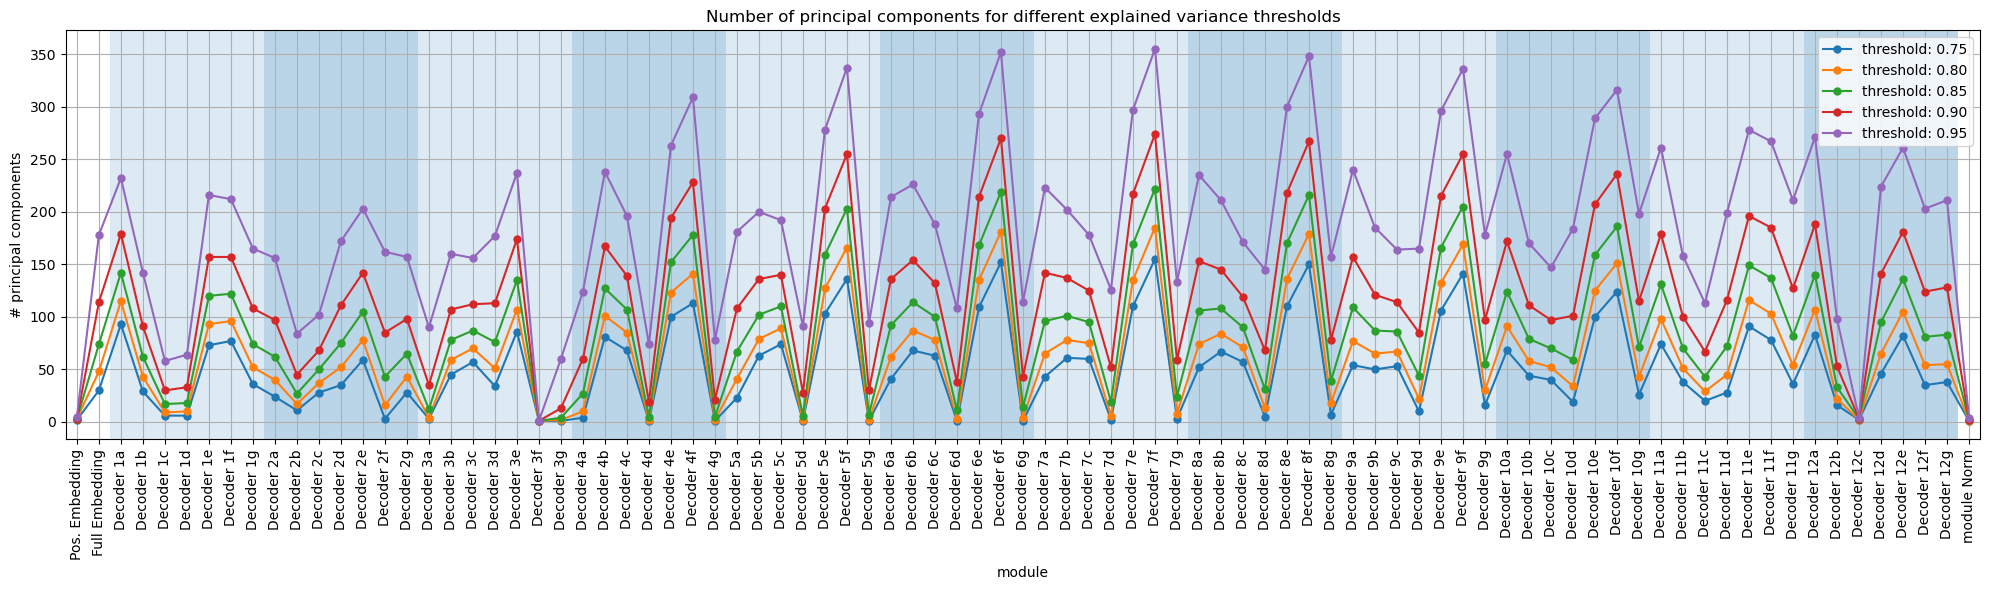

In [8]:
# create figure
fig, ax = plt.subplots(figsize=(20, 6))

for i, t in enumerate(thresholds):
    ax.plot(x_pos[1:], n_components_threshold[i], ls="-", marker="o", markersize=5, zorder=4, label=f"threshold: {t:.2f}")

# visualize decoder blocks
# you can comment this out if you think it's too much
for i in range(0, 12):
    if i%2:
        plt.axvspan(i*7+2.5, i*7+9.5, facecolor="tab:blue", alpha=0.3, zorder=-100)
    else:
        plt.axvspan(i*7+2.5, i*7+9.5, facecolor="tab:blue", alpha=0.15, zorder=-100)

ax.set_title(f"Number of principal components for different explained variance thresholds")
ax.set_xlabel("module")
ax.set_ylabel("# principal components")
ax.set_xticks(x_pos[1:], ticks[1:], rotation=90)
ax.set_xlim(min(x_pos[1:])-0.5, max(x_pos)+0.5)
ax.grid()
ax.legend()
fig.tight_layout()
plt.show()

## Comparison of 2NN and PCA

Direct comparison:

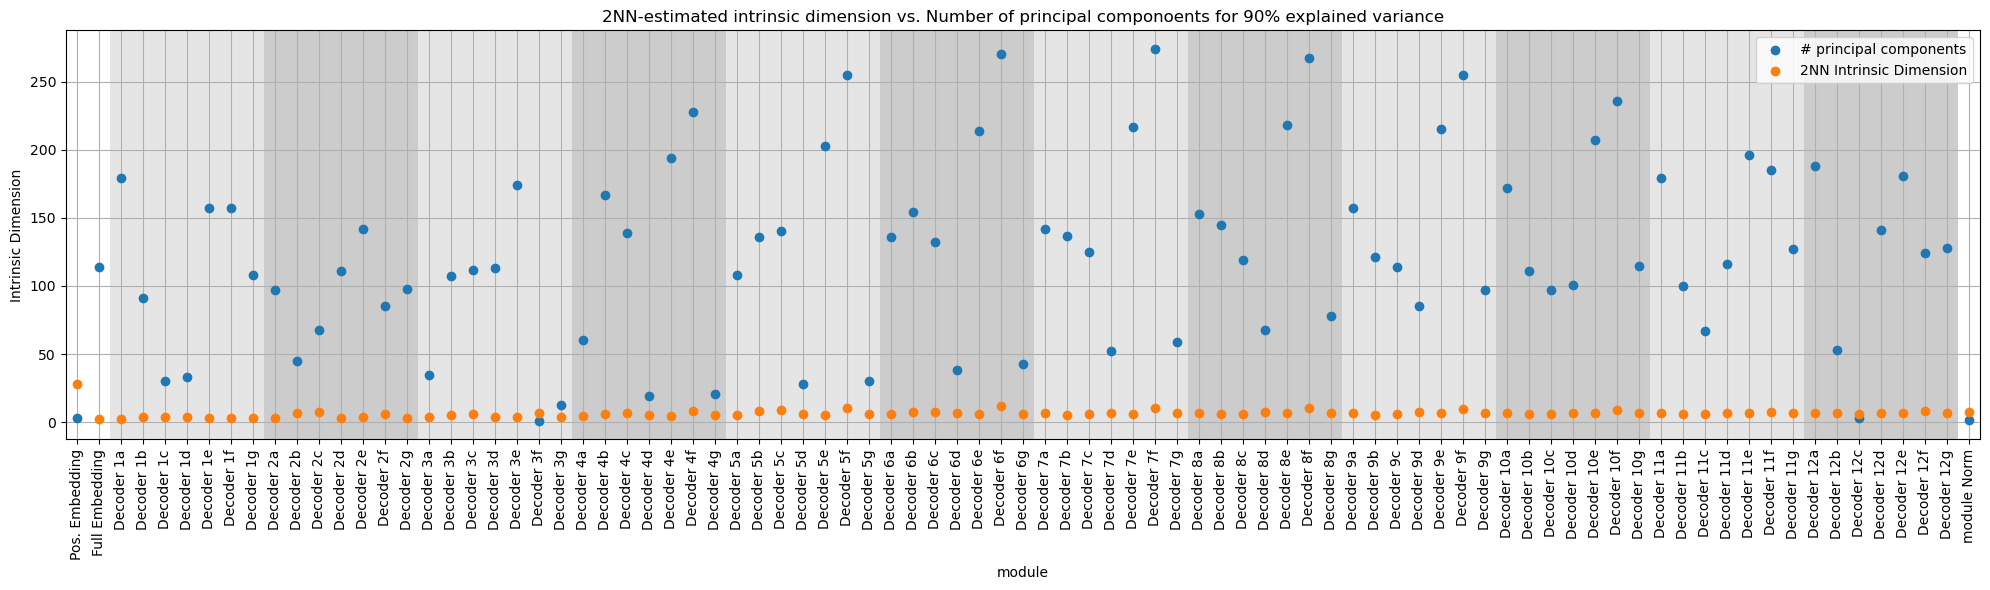

In [9]:
# create figure
fig, ax = plt.subplots(figsize=(20, 6))

ax.scatter(x_pos[1:], n_components_needed, zorder=4, label= "# principal components")
ax.scatter(x_pos[1:], ids, zorder=4, label = "2NN Intrinsic Dimension")

# visualize decoder blocks
for i in range(0, 12):
    if i%2:
        plt.axvspan(i*7+2.5, i*7+9.5, facecolor="grey", alpha=0.4, zorder=-100)
    else:
        plt.axvspan(i*7+2.5, i*7+9.5, facecolor="grey", alpha=0.2, zorder=-100)

ax.set_title(f"2NN-estimated intrinsic dimension vs. Number of principal componoents for 90% explained variance")
ax.set_xlabel("module")
ax.set_ylabel("Intrinsic Dimension")
ax.set_xticks(x_pos[1:], ticks[1:], rotation=90)
ax.set_xlim(min(x_pos[1:])-0.5, max(x_pos)+0.5)
ax.grid()
ax.legend()
fig.tight_layout()
plt.show()

Using 2 separate y-axes for both datasets:

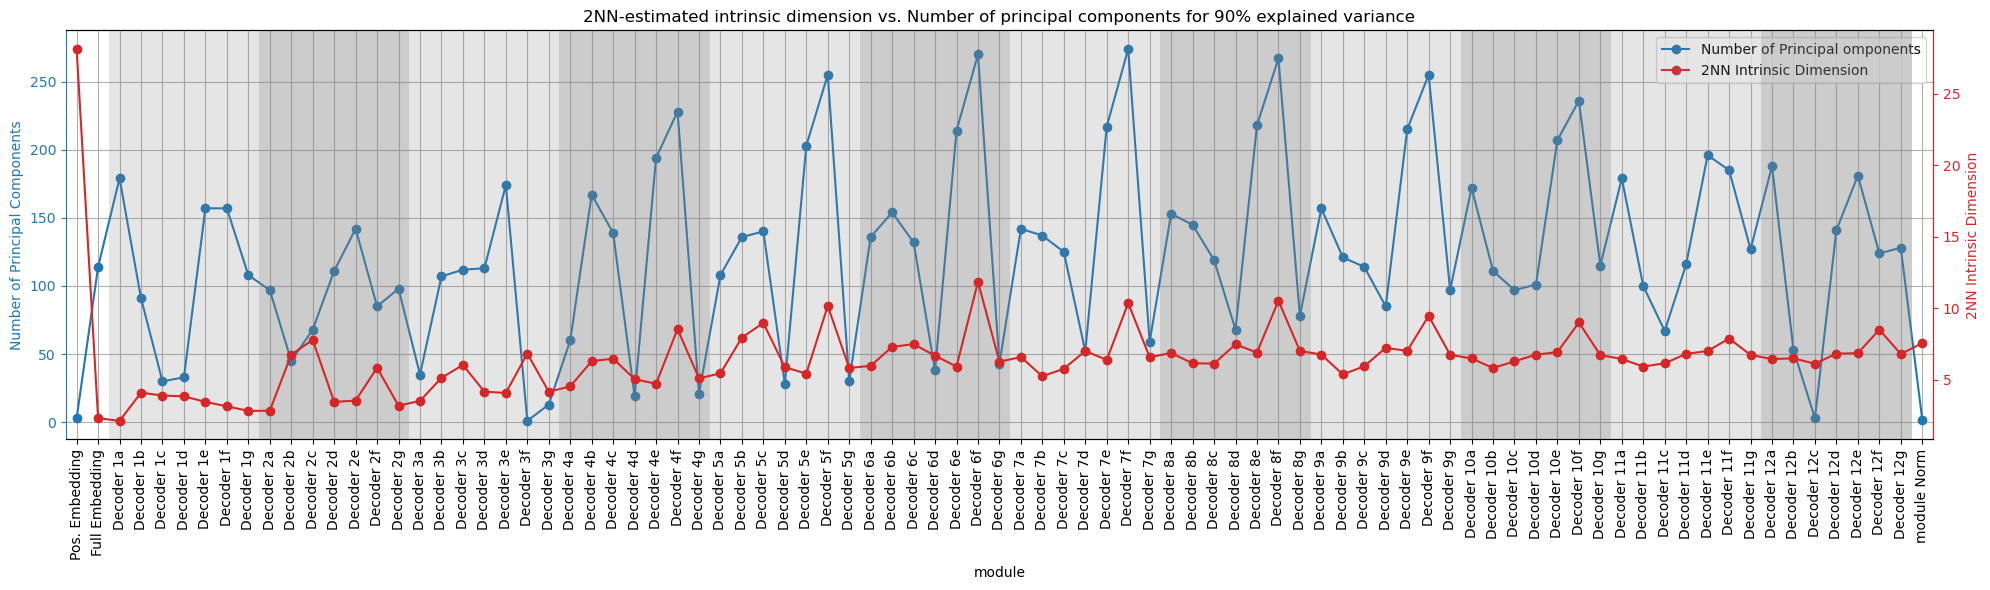

In [10]:
# create figure with twin axis
fig, ax1 = plt.subplots(figsize=(20, 6))
ax2 = ax1.twinx()

# plot PCA results
color1 = 'tab:blue'
scatter1 = ax1.plot(x_pos[1:], n_components_needed, zorder=4, label="Number of Principal omponents", color=color1, marker="o")
ax1.set_ylabel("Number of Principal Components", color=color1)
ax1.tick_params(axis='y', labelcolor=color1, color=color1)
ax1.spines['left'].set_color(color1)

# plot 2NN results
color2 = 'tab:red'
scatter2 = ax2.plot(x_pos[1:], ids, zorder=4, label="2NN Intrinsic Dimension", color=color2, marker="o")
ax2.set_ylabel("2NN Intrinsic Dimension", color=color2)
ax2.tick_params(axis='y', labelcolor=color2, color=color2)
ax2.spines['right'].set_color(color2)
ax2.spines['left'].set_color('none')


# Visualize decoder blocks
for i in range(0, 12):
    if i % 2:
        plt.axvspan(i * 7 + 2.5, i * 7 + 9.5, facecolor="grey", alpha=0.4, zorder=-100)
    else:
        plt.axvspan(i * 7 + 2.5, i * 7 + 9.5, facecolor="grey", alpha=0.2, zorder=-100)

ax1.set_title("2NN-estimated intrinsic dimension vs. Number of principal components for 90% explained variance")
ax1.set_xlabel("module")
ax1.set_xticks(x_pos[1:], ticks[1:], rotation=90)
ax1.set_xlim(min(x_pos[1:]) - 0.5, max(x_pos) + 0.5)
ax1.grid()

# legend
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='best')

fig.tight_layout()
plt.show()